In [1]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import callbacks
import os
import cv2
import string
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

#Init main values
# symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
symbols = "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (62, 175, 1)

In [2]:
print(num_symbols)

10


In [3]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    #we have 6 letters
    for _ in range(6):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

Importing Data

In [4]:
def preprocess_data():
    n_samples = len(os.listdir('data/wetax'))
    X = np.zeros((n_samples, 62, 175, 1)) #1070*62*175
    y = np.zeros((6, n_samples, num_symbols)) #6*1070*10

    for i, pic in enumerate(os.listdir('data/wetax')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('data/wetax', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 7:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (62, 175, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((6, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]
print(str(len(X_train)) + " training samples")
print(str(len(X_test)) + " validation samples")


970 training samples
134 validation samples


In [5]:
model=create_model();
model.summary();

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 62, 175, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 62, 175, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 31, 88, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 31, 88, 32)   4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [6]:
#model = create_model()
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4], y_train[5]], batch_size=32, epochs=500,verbose=1, validation_split=0.2)

Epoch 1/500
25/25 [==============================] - 3s 34ms/step - loss: 13.8457 - dense_1_loss: 2.0925 - dense_3_loss: 2.3587 - dense_5_loss: 2.3424 - dense_7_loss: 2.3501 - dense_9_loss: 2.3614 - dense_11_loss: 2.3405 - dense_1_accuracy: 0.2320 - dense_3_accuracy: 0.0851 - dense_5_accuracy: 0.1327 - dense_7_accuracy: 0.1070 - dense_9_accuracy: 0.1224 - dense_11_accuracy: 0.1186 - val_loss: 13.8626 - val_dense_1_loss: 2.3514 - val_dense_3_loss: 2.2998 - val_dense_5_loss: 2.3024 - val_dense_7_loss: 2.3001 - val_dense_9_loss: 2.3089 - val_dense_11_loss: 2.3001 - val_dense_1_accuracy: 0.0000e+00 - val_dense_3_accuracy: 0.1289 - val_dense_5_accuracy: 0.1186 - val_dense_7_accuracy: 0.1495 - val_dense_9_accuracy: 0.0773 - val_dense_11_accuracy: 0.1082
Epoch 2/500
25/25 [==============================] - 0s 16ms/step - loss: 11.9993 - dense_1_loss: 1.2405 - dense_3_loss: 2.1301 - dense_5_loss: 2.1289 - dense_7_loss: 2.1735 - dense_9_loss: 2.1512 - dense_11_loss: 2.1750 - dense_1_accuracy: 0

Epoch 12/500
25/25 [==============================] - 0s 16ms/step - loss: 2.4135 - dense_1_loss: 0.0507 - dense_3_loss: 0.3645 - dense_5_loss: 0.3601 - dense_7_loss: 0.4739 - dense_9_loss: 0.5388 - dense_11_loss: 0.6256 - dense_1_accuracy: 0.9832 - dense_3_accuracy: 0.8608 - dense_5_accuracy: 0.8647 - dense_7_accuracy: 0.8196 - dense_9_accuracy: 0.7784 - dense_11_accuracy: 0.7590 - val_loss: 9.7743 - val_dense_1_loss: 4.6594 - val_dense_3_loss: 0.9247 - val_dense_5_loss: 0.8965 - val_dense_7_loss: 1.0508 - val_dense_9_loss: 1.1747 - val_dense_11_loss: 1.0682 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9588 - val_dense_5_accuracy: 0.9691 - val_dense_7_accuracy: 0.9175 - val_dense_9_accuracy: 0.8814 - val_dense_11_accuracy: 0.9485
Epoch 13/500
25/25 [==============================] - 0s 15ms/step - loss: 2.2740 - dense_1_loss: 0.0282 - dense_3_loss: 0.3777 - dense_5_loss: 0.3953 - dense_7_loss: 0.4106 - dense_9_loss: 0.4897 - dense_11_loss: 0.5725 - dense_1_accuracy: 0.9936

Epoch 23/500
25/25 [==============================] - 0s 16ms/step - loss: 1.4421 - dense_1_loss: 0.0254 - dense_3_loss: 0.2472 - dense_5_loss: 0.2479 - dense_7_loss: 0.2413 - dense_9_loss: 0.3112 - dense_11_loss: 0.3692 - dense_1_accuracy: 0.9923 - dense_3_accuracy: 0.8853 - dense_5_accuracy: 0.8918 - dense_7_accuracy: 0.8956 - dense_9_accuracy: 0.8789 - dense_11_accuracy: 0.8351 - val_loss: 17.2189 - val_dense_1_loss: 16.3405 - val_dense_3_loss: 0.1143 - val_dense_5_loss: 0.0930 - val_dense_7_loss: 0.2245 - val_dense_9_loss: 0.3080 - val_dense_11_loss: 0.1387 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9794 - val_dense_5_accuracy: 0.9845 - val_dense_7_accuracy: 0.9278 - val_dense_9_accuracy: 0.9124 - val_dense_11_accuracy: 0.9691
Epoch 24/500
25/25 [==============================] - 0s 16ms/step - loss: 1.3818 - dense_1_loss: 0.0290 - dense_3_loss: 0.2286 - dense_5_loss: 0.2134 - dense_7_loss: 0.2507 - dense_9_loss: 0.2792 - dense_11_loss: 0.3808 - dense_1_accuracy: 0.98

Epoch 34/500
25/25 [==============================] - 0s 16ms/step - loss: 1.0013 - dense_1_loss: 0.0266 - dense_3_loss: 0.1760 - dense_5_loss: 0.1500 - dense_7_loss: 0.1720 - dense_9_loss: 0.2139 - dense_11_loss: 0.2628 - dense_1_accuracy: 0.9897 - dense_3_accuracy: 0.9330 - dense_5_accuracy: 0.9459 - dense_7_accuracy: 0.9291 - dense_9_accuracy: 0.9343 - dense_11_accuracy: 0.8905 - val_loss: 22.6862 - val_dense_1_loss: 21.7614 - val_dense_3_loss: 0.0914 - val_dense_5_loss: 0.0522 - val_dense_7_loss: 0.2022 - val_dense_9_loss: 0.4763 - val_dense_11_loss: 0.1027 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9794 - val_dense_7_accuracy: 0.9175 - val_dense_9_accuracy: 0.9021 - val_dense_11_accuracy: 0.9794
Epoch 35/500
25/25 [==============================] - 0s 16ms/step - loss: 1.0557 - dense_1_loss: 0.0222 - dense_3_loss: 0.1852 - dense_5_loss: 0.1668 - dense_7_loss: 0.1811 - dense_9_loss: 0.2086 - dense_11_loss: 0.2918 - dense_1_accuracy: 0.98

Epoch 45/500
25/25 [==============================] - 0s 16ms/step - loss: 0.8087 - dense_1_loss: 0.0196 - dense_3_loss: 0.1384 - dense_5_loss: 0.1231 - dense_7_loss: 0.1387 - dense_9_loss: 0.1892 - dense_11_loss: 0.1997 - dense_1_accuracy: 0.9910 - dense_3_accuracy: 0.9407 - dense_5_accuracy: 0.9549 - dense_7_accuracy: 0.9446 - dense_9_accuracy: 0.9330 - dense_11_accuracy: 0.9214 - val_loss: 26.0088 - val_dense_1_loss: 25.2680 - val_dense_3_loss: 0.1161 - val_dense_5_loss: 0.0156 - val_dense_7_loss: 0.1135 - val_dense_9_loss: 0.3867 - val_dense_11_loss: 0.1088 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9639 - val_dense_9_accuracy: 0.9227 - val_dense_11_accuracy: 0.9639
Epoch 46/500
25/25 [==============================] - 0s 16ms/step - loss: 0.7862 - dense_1_loss: 0.0176 - dense_3_loss: 0.1379 - dense_5_loss: 0.1240 - dense_7_loss: 0.1197 - dense_9_loss: 0.1861 - dense_11_loss: 0.2010 - dense_1_accuracy: 0.99

Epoch 56/500
25/25 [==============================] - 0s 16ms/step - loss: 0.7169 - dense_1_loss: 0.0153 - dense_3_loss: 0.1214 - dense_5_loss: 0.1423 - dense_7_loss: 0.1243 - dense_9_loss: 0.1805 - dense_11_loss: 0.1331 - dense_1_accuracy: 0.9923 - dense_3_accuracy: 0.9510 - dense_5_accuracy: 0.9381 - dense_7_accuracy: 0.9485 - dense_9_accuracy: 0.9278 - dense_11_accuracy: 0.9407 - val_loss: 26.2776 - val_dense_1_loss: 25.4722 - val_dense_3_loss: 0.1600 - val_dense_5_loss: 0.0678 - val_dense_7_loss: 0.1925 - val_dense_9_loss: 0.3384 - val_dense_11_loss: 0.0467 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9845 - val_dense_7_accuracy: 0.9536 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 0.9845
Epoch 57/500
25/25 [==============================] - 0s 16ms/step - loss: 0.6713 - dense_1_loss: 0.0250 - dense_3_loss: 0.1088 - dense_5_loss: 0.1160 - dense_7_loss: 0.1003 - dense_9_loss: 0.1566 - dense_11_loss: 0.1646 - dense_1_accuracy: 0.99

Epoch 67/500
25/25 [==============================] - 0s 16ms/step - loss: 0.6027 - dense_1_loss: 0.0124 - dense_3_loss: 0.1023 - dense_5_loss: 0.1222 - dense_7_loss: 0.0999 - dense_9_loss: 0.1091 - dense_11_loss: 0.1568 - dense_1_accuracy: 0.9948 - dense_3_accuracy: 0.9601 - dense_5_accuracy: 0.9433 - dense_7_accuracy: 0.9652 - dense_9_accuracy: 0.9601 - dense_11_accuracy: 0.9394 - val_loss: 26.6124 - val_dense_1_loss: 25.6637 - val_dense_3_loss: 0.1695 - val_dense_5_loss: 0.0173 - val_dense_7_loss: 0.1750 - val_dense_9_loss: 0.4503 - val_dense_11_loss: 0.1366 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9948 - val_dense_7_accuracy: 0.9639 - val_dense_9_accuracy: 0.9381 - val_dense_11_accuracy: 0.9742
Epoch 68/500
25/25 [==============================] - 0s 16ms/step - loss: 0.6348 - dense_1_loss: 0.0105 - dense_3_loss: 0.1044 - dense_5_loss: 0.1336 - dense_7_loss: 0.1182 - dense_9_loss: 0.1238 - dense_11_loss: 0.1444 - dense_1_accuracy: 0.99

Epoch 78/500
25/25 [==============================] - 0s 16ms/step - loss: 0.5110 - dense_1_loss: 0.0185 - dense_3_loss: 0.0908 - dense_5_loss: 0.0800 - dense_7_loss: 0.1025 - dense_9_loss: 0.0866 - dense_11_loss: 0.1327 - dense_1_accuracy: 0.9948 - dense_3_accuracy: 0.9588 - dense_5_accuracy: 0.9626 - dense_7_accuracy: 0.9562 - dense_9_accuracy: 0.9639 - dense_11_accuracy: 0.9485 - val_loss: 23.9862 - val_dense_1_loss: 22.9889 - val_dense_3_loss: 0.1682 - val_dense_5_loss: 0.0208 - val_dense_7_loss: 0.1892 - val_dense_9_loss: 0.5187 - val_dense_11_loss: 0.1005 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9897 - val_dense_7_accuracy: 0.9536 - val_dense_9_accuracy: 0.9381 - val_dense_11_accuracy: 0.9742
Epoch 79/500
25/25 [==============================] - 0s 16ms/step - loss: 0.5218 - dense_1_loss: 0.0110 - dense_3_loss: 0.0697 - dense_5_loss: 0.0942 - dense_7_loss: 0.0897 - dense_9_loss: 0.1220 - dense_11_loss: 0.1351 - dense_1_accuracy: 0.99

Epoch 89/500
25/25 [==============================] - 0s 16ms/step - loss: 0.4917 - dense_1_loss: 0.0358 - dense_3_loss: 0.0558 - dense_5_loss: 0.0895 - dense_7_loss: 0.0822 - dense_9_loss: 0.1034 - dense_11_loss: 0.1250 - dense_1_accuracy: 0.9923 - dense_3_accuracy: 0.9781 - dense_5_accuracy: 0.9613 - dense_7_accuracy: 0.9729 - dense_9_accuracy: 0.9562 - dense_11_accuracy: 0.9510 - val_loss: 33.8426 - val_dense_1_loss: 32.9834 - val_dense_3_loss: 0.1694 - val_dense_5_loss: 0.0678 - val_dense_7_loss: 0.1277 - val_dense_9_loss: 0.4159 - val_dense_11_loss: 0.0784 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9897 - val_dense_5_accuracy: 0.9845 - val_dense_7_accuracy: 0.9588 - val_dense_9_accuracy: 0.9381 - val_dense_11_accuracy: 0.9845
Epoch 90/500
25/25 [==============================] - 0s 16ms/step - loss: 0.4170 - dense_1_loss: 0.0187 - dense_3_loss: 0.0522 - dense_5_loss: 0.0628 - dense_7_loss: 0.0822 - dense_9_loss: 0.1078 - dense_11_loss: 0.0933 - dense_1_accuracy: 0.99

Epoch 100/500
25/25 [==============================] - 0s 16ms/step - loss: 0.3745 - dense_1_loss: 0.0150 - dense_3_loss: 0.0557 - dense_5_loss: 0.0601 - dense_7_loss: 0.0830 - dense_9_loss: 0.0853 - dense_11_loss: 0.0754 - dense_1_accuracy: 0.9910 - dense_3_accuracy: 0.9794 - dense_5_accuracy: 0.9845 - dense_7_accuracy: 0.9652 - dense_9_accuracy: 0.9652 - dense_11_accuracy: 0.9678 - val_loss: 30.4835 - val_dense_1_loss: 29.5724 - val_dense_3_loss: 0.1689 - val_dense_5_loss: 0.0548 - val_dense_7_loss: 0.1639 - val_dense_9_loss: 0.4447 - val_dense_11_loss: 0.0788 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9897 - val_dense_5_accuracy: 0.9845 - val_dense_7_accuracy: 0.9691 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 0.9794
Epoch 101/500
25/25 [==============================] - 0s 16ms/step - loss: 0.3847 - dense_1_loss: 0.0061 - dense_3_loss: 0.0491 - dense_5_loss: 0.0609 - dense_7_loss: 0.0711 - dense_9_loss: 0.1116 - dense_11_loss: 0.0858 - dense_1_accuracy: 0.

Epoch 111/500
25/25 [==============================] - 0s 16ms/step - loss: 0.3485 - dense_1_loss: 0.0118 - dense_3_loss: 0.0468 - dense_5_loss: 0.0747 - dense_7_loss: 0.0477 - dense_9_loss: 0.0966 - dense_11_loss: 0.0708 - dense_1_accuracy: 0.9948 - dense_3_accuracy: 0.9794 - dense_5_accuracy: 0.9729 - dense_7_accuracy: 0.9807 - dense_9_accuracy: 0.9510 - dense_11_accuracy: 0.9704 - val_loss: 33.7760 - val_dense_1_loss: 33.0196 - val_dense_3_loss: 0.1343 - val_dense_5_loss: 0.0086 - val_dense_7_loss: 0.0979 - val_dense_9_loss: 0.4468 - val_dense_11_loss: 0.0688 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9897 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9536 - val_dense_9_accuracy: 0.9485 - val_dense_11_accuracy: 0.9794
Epoch 112/500
25/25 [==============================] - 0s 16ms/step - loss: 0.3129 - dense_1_loss: 0.0068 - dense_3_loss: 0.0522 - dense_5_loss: 0.0575 - dense_7_loss: 0.0629 - dense_9_loss: 0.0665 - dense_11_loss: 0.0671 - dense_1_accuracy: 0.

Epoch 122/500
25/25 [==============================] - 0s 16ms/step - loss: 0.3385 - dense_1_loss: 0.0260 - dense_3_loss: 0.0442 - dense_5_loss: 0.0540 - dense_7_loss: 0.0619 - dense_9_loss: 0.0919 - dense_11_loss: 0.0604 - dense_1_accuracy: 0.9923 - dense_3_accuracy: 0.9807 - dense_5_accuracy: 0.9716 - dense_7_accuracy: 0.9781 - dense_9_accuracy: 0.9601 - dense_11_accuracy: 0.9742 - val_loss: 19.7853 - val_dense_1_loss: 18.8626 - val_dense_3_loss: 0.1540 - val_dense_5_loss: 0.0194 - val_dense_7_loss: 0.1545 - val_dense_9_loss: 0.5389 - val_dense_11_loss: 0.0558 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9948 - val_dense_7_accuracy: 0.9639 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 0.9794
Epoch 123/500
25/25 [==============================] - 0s 16ms/step - loss: 0.3017 - dense_1_loss: 0.0144 - dense_3_loss: 0.0394 - dense_5_loss: 0.0505 - dense_7_loss: 0.0602 - dense_9_loss: 0.0849 - dense_11_loss: 0.0523 - dense_1_accuracy: 0.

Epoch 133/500
25/25 [==============================] - 0s 16ms/step - loss: 0.3281 - dense_1_loss: 0.0147 - dense_3_loss: 0.0689 - dense_5_loss: 0.0748 - dense_7_loss: 0.0558 - dense_9_loss: 0.0594 - dense_11_loss: 0.0545 - dense_1_accuracy: 0.9936 - dense_3_accuracy: 0.9742 - dense_5_accuracy: 0.9768 - dense_7_accuracy: 0.9807 - dense_9_accuracy: 0.9768 - dense_11_accuracy: 0.9794 - val_loss: 23.0960 - val_dense_1_loss: 21.9218 - val_dense_3_loss: 0.1527 - val_dense_5_loss: 0.0511 - val_dense_7_loss: 0.1928 - val_dense_9_loss: 0.6458 - val_dense_11_loss: 0.1317 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9742 - val_dense_7_accuracy: 0.9588 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 0.9794
Epoch 134/500
25/25 [==============================] - 0s 16ms/step - loss: 0.3564 - dense_1_loss: 0.0047 - dense_3_loss: 0.0667 - dense_5_loss: 0.0563 - dense_7_loss: 0.0781 - dense_9_loss: 0.0767 - dense_11_loss: 0.0739 - dense_1_accuracy: 0.

Epoch 144/500
25/25 [==============================] - 0s 16ms/step - loss: 0.2628 - dense_1_loss: 0.0034 - dense_3_loss: 0.0359 - dense_5_loss: 0.0439 - dense_7_loss: 0.0361 - dense_9_loss: 0.0912 - dense_11_loss: 0.0523 - dense_1_accuracy: 0.9987 - dense_3_accuracy: 0.9871 - dense_5_accuracy: 0.9832 - dense_7_accuracy: 0.9820 - dense_9_accuracy: 0.9729 - dense_11_accuracy: 0.9781 - val_loss: 26.3571 - val_dense_1_loss: 25.4616 - val_dense_3_loss: 0.1525 - val_dense_5_loss: 0.0380 - val_dense_7_loss: 0.1228 - val_dense_9_loss: 0.5070 - val_dense_11_loss: 0.0752 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9845 - val_dense_7_accuracy: 0.9691 - val_dense_9_accuracy: 0.9485 - val_dense_11_accuracy: 0.9897
Epoch 145/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1974 - dense_1_loss: 0.0134 - dense_3_loss: 0.0214 - dense_5_loss: 0.0343 - dense_7_loss: 0.0506 - dense_9_loss: 0.0416 - dense_11_loss: 0.0362 - dense_1_accuracy: 0.

Epoch 155/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1889 - dense_1_loss: 0.0098 - dense_3_loss: 0.0337 - dense_5_loss: 0.0280 - dense_7_loss: 0.0265 - dense_9_loss: 0.0493 - dense_11_loss: 0.0416 - dense_1_accuracy: 0.9974 - dense_3_accuracy: 0.9884 - dense_5_accuracy: 0.9884 - dense_7_accuracy: 0.9871 - dense_9_accuracy: 0.9781 - dense_11_accuracy: 0.9845 - val_loss: 31.9623 - val_dense_1_loss: 30.8698 - val_dense_3_loss: 0.1836 - val_dense_5_loss: 0.0210 - val_dense_7_loss: 0.1975 - val_dense_9_loss: 0.6481 - val_dense_11_loss: 0.0423 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9845 - val_dense_7_accuracy: 0.9691 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 0.9948
Epoch 156/500
25/25 [==============================] - 0s 16ms/step - loss: 0.2364 - dense_1_loss: 0.0076 - dense_3_loss: 0.0336 - dense_5_loss: 0.0383 - dense_7_loss: 0.0365 - dense_9_loss: 0.0682 - dense_11_loss: 0.0522 - dense_1_accuracy: 0.

Epoch 166/500
25/25 [==============================] - 0s 16ms/step - loss: 0.2563 - dense_1_loss: 0.0153 - dense_3_loss: 0.0364 - dense_5_loss: 0.0451 - dense_7_loss: 0.0420 - dense_9_loss: 0.0593 - dense_11_loss: 0.0581 - dense_1_accuracy: 0.9974 - dense_3_accuracy: 0.9858 - dense_5_accuracy: 0.9807 - dense_7_accuracy: 0.9845 - dense_9_accuracy: 0.9704 - dense_11_accuracy: 0.9781 - val_loss: 25.8670 - val_dense_1_loss: 25.0789 - val_dense_3_loss: 0.1202 - val_dense_5_loss: 0.0365 - val_dense_7_loss: 0.1332 - val_dense_9_loss: 0.4519 - val_dense_11_loss: 0.0462 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9845 - val_dense_7_accuracy: 0.9588 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 0.9897
Epoch 167/500
25/25 [==============================] - 0s 16ms/step - loss: 0.2165 - dense_1_loss: 0.0056 - dense_3_loss: 0.0326 - dense_5_loss: 0.0515 - dense_7_loss: 0.0425 - dense_9_loss: 0.0475 - dense_11_loss: 0.0368 - dense_1_accuracy: 0.

Epoch 177/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1937 - dense_1_loss: 0.0032 - dense_3_loss: 0.0371 - dense_5_loss: 0.0309 - dense_7_loss: 0.0334 - dense_9_loss: 0.0377 - dense_11_loss: 0.0514 - dense_1_accuracy: 0.9974 - dense_3_accuracy: 0.9820 - dense_5_accuracy: 0.9884 - dense_7_accuracy: 0.9884 - dense_9_accuracy: 0.9832 - dense_11_accuracy: 0.9742 - val_loss: 29.4314 - val_dense_1_loss: 28.5527 - val_dense_3_loss: 0.1522 - val_dense_5_loss: 0.0504 - val_dense_7_loss: 0.0924 - val_dense_9_loss: 0.5286 - val_dense_11_loss: 0.0551 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9897 - val_dense_7_accuracy: 0.9742 - val_dense_9_accuracy: 0.9381 - val_dense_11_accuracy: 0.9948
Epoch 178/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1666 - dense_1_loss: 0.0018 - dense_3_loss: 0.0292 - dense_5_loss: 0.0140 - dense_7_loss: 0.0350 - dense_9_loss: 0.0367 - dense_11_loss: 0.0499 - dense_1_accuracy: 1.

Epoch 188/500
25/25 [==============================] - 0s 16ms/step - loss: 0.2214 - dense_1_loss: 0.0046 - dense_3_loss: 0.0316 - dense_5_loss: 0.0263 - dense_7_loss: 0.0369 - dense_9_loss: 0.0726 - dense_11_loss: 0.0491 - dense_1_accuracy: 0.9961 - dense_3_accuracy: 0.9897 - dense_5_accuracy: 0.9884 - dense_7_accuracy: 0.9832 - dense_9_accuracy: 0.9742 - dense_11_accuracy: 0.9820 - val_loss: 35.0600 - val_dense_1_loss: 34.0926 - val_dense_3_loss: 0.1739 - val_dense_5_loss: 0.0042 - val_dense_7_loss: 0.0898 - val_dense_9_loss: 0.6252 - val_dense_11_loss: 0.0742 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9691 - val_dense_9_accuracy: 0.9381 - val_dense_11_accuracy: 0.9794
Epoch 189/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1547 - dense_1_loss: 0.0016 - dense_3_loss: 0.0213 - dense_5_loss: 0.0226 - dense_7_loss: 0.0609 - dense_9_loss: 0.0277 - dense_11_loss: 0.0206 - dense_1_accuracy: 1.

Epoch 199/500
25/25 [==============================] - 0s 16ms/step - loss: 0.2047 - dense_1_loss: 0.0214 - dense_3_loss: 0.0446 - dense_5_loss: 0.0241 - dense_7_loss: 0.0287 - dense_9_loss: 0.0318 - dense_11_loss: 0.0540 - dense_1_accuracy: 0.9948 - dense_3_accuracy: 0.9845 - dense_5_accuracy: 0.9923 - dense_7_accuracy: 0.9948 - dense_9_accuracy: 0.9910 - dense_11_accuracy: 0.9845 - val_loss: 23.0587 - val_dense_1_loss: 22.1446 - val_dense_3_loss: 0.1458 - val_dense_5_loss: 0.0190 - val_dense_7_loss: 0.1237 - val_dense_9_loss: 0.5555 - val_dense_11_loss: 0.0701 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9948 - val_dense_7_accuracy: 0.9691 - val_dense_9_accuracy: 0.9485 - val_dense_11_accuracy: 0.9845
Epoch 200/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1618 - dense_1_loss: 0.0070 - dense_3_loss: 0.0268 - dense_5_loss: 0.0217 - dense_7_loss: 0.0241 - dense_9_loss: 0.0331 - dense_11_loss: 0.0492 - dense_1_accuracy: 0.

Epoch 210/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1655 - dense_1_loss: 4.0936e-04 - dense_3_loss: 0.0320 - dense_5_loss: 0.0422 - dense_7_loss: 0.0269 - dense_9_loss: 0.0426 - dense_11_loss: 0.0214 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9884 - dense_5_accuracy: 0.9884 - dense_7_accuracy: 0.9910 - dense_9_accuracy: 0.9845 - dense_11_accuracy: 0.9936 - val_loss: 32.8959 - val_dense_1_loss: 31.6603 - val_dense_3_loss: 0.2184 - val_dense_5_loss: 0.0123 - val_dense_7_loss: 0.0986 - val_dense_9_loss: 0.7899 - val_dense_11_loss: 0.1163 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9948 - val_dense_7_accuracy: 0.9742 - val_dense_9_accuracy: 0.9330 - val_dense_11_accuracy: 0.9897
Epoch 211/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1504 - dense_1_loss: 0.0036 - dense_3_loss: 0.0090 - dense_5_loss: 0.0297 - dense_7_loss: 0.0478 - dense_9_loss: 0.0333 - dense_11_loss: 0.0270 - dense_1_accuracy

Epoch 221/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1064 - dense_1_loss: 0.0019 - dense_3_loss: 0.0229 - dense_5_loss: 0.0207 - dense_7_loss: 0.0063 - dense_9_loss: 0.0341 - dense_11_loss: 0.0205 - dense_1_accuracy: 0.9987 - dense_3_accuracy: 0.9897 - dense_5_accuracy: 0.9948 - dense_7_accuracy: 0.9987 - dense_9_accuracy: 0.9871 - dense_11_accuracy: 0.9923 - val_loss: 30.6886 - val_dense_1_loss: 29.6795 - val_dense_3_loss: 0.1982 - val_dense_5_loss: 0.0021 - val_dense_7_loss: 0.1908 - val_dense_9_loss: 0.5955 - val_dense_11_loss: 0.0224 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9691 - val_dense_9_accuracy: 0.9278 - val_dense_11_accuracy: 0.9897
Epoch 222/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1362 - dense_1_loss: 0.0010 - dense_3_loss: 0.0201 - dense_5_loss: 0.0172 - dense_7_loss: 0.0334 - dense_9_loss: 0.0290 - dense_11_loss: 0.0354 - dense_1_accuracy: 1.

Epoch 232/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1785 - dense_1_loss: 0.0123 - dense_3_loss: 0.0233 - dense_5_loss: 0.0347 - dense_7_loss: 0.0476 - dense_9_loss: 0.0432 - dense_11_loss: 0.0174 - dense_1_accuracy: 0.9936 - dense_3_accuracy: 0.9884 - dense_5_accuracy: 0.9858 - dense_7_accuracy: 0.9884 - dense_9_accuracy: 0.9858 - dense_11_accuracy: 0.9897 - val_loss: 36.9972 - val_dense_1_loss: 35.8710 - val_dense_3_loss: 0.2115 - val_dense_5_loss: 0.0126 - val_dense_7_loss: 0.2180 - val_dense_9_loss: 0.6225 - val_dense_11_loss: 0.0615 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9948 - val_dense_7_accuracy: 0.9588 - val_dense_9_accuracy: 0.9278 - val_dense_11_accuracy: 0.9948
Epoch 233/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1794 - dense_1_loss: 0.0256 - dense_3_loss: 0.0259 - dense_5_loss: 0.0379 - dense_7_loss: 0.0199 - dense_9_loss: 0.0385 - dense_11_loss: 0.0316 - dense_1_accuracy: 0.

Epoch 243/500
25/25 [==============================] - 0s 15ms/step - loss: 0.1104 - dense_1_loss: 0.0056 - dense_3_loss: 0.0134 - dense_5_loss: 0.0177 - dense_7_loss: 0.0259 - dense_9_loss: 0.0314 - dense_11_loss: 0.0164 - dense_1_accuracy: 0.9974 - dense_3_accuracy: 0.9936 - dense_5_accuracy: 0.9961 - dense_7_accuracy: 0.9871 - dense_9_accuracy: 0.9897 - dense_11_accuracy: 0.9936 - val_loss: 37.2875 - val_dense_1_loss: 36.2405 - val_dense_3_loss: 0.2499 - val_dense_5_loss: 3.5599e-05 - val_dense_7_loss: 0.1734 - val_dense_9_loss: 0.5571 - val_dense_11_loss: 0.0666 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9742 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 0.9948
Epoch 244/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1472 - dense_1_loss: 0.0116 - dense_3_loss: 0.0234 - dense_5_loss: 0.0128 - dense_7_loss: 0.0263 - dense_9_loss: 0.0421 - dense_11_loss: 0.0312 - dense_1_accuracy

Epoch 254/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1166 - dense_1_loss: 0.0090 - dense_3_loss: 0.0110 - dense_5_loss: 0.0171 - dense_7_loss: 0.0332 - dense_9_loss: 0.0264 - dense_11_loss: 0.0200 - dense_1_accuracy: 0.9974 - dense_3_accuracy: 0.9948 - dense_5_accuracy: 0.9936 - dense_7_accuracy: 0.9871 - dense_9_accuracy: 0.9910 - dense_11_accuracy: 0.9897 - val_loss: 24.7188 - val_dense_1_loss: 23.7848 - val_dense_3_loss: 0.2167 - val_dense_5_loss: 2.8827e-04 - val_dense_7_loss: 0.2264 - val_dense_9_loss: 0.4741 - val_dense_11_loss: 0.0165 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9897 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9588 - val_dense_9_accuracy: 0.9485 - val_dense_11_accuracy: 0.9897
Epoch 255/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1059 - dense_1_loss: 0.0025 - dense_3_loss: 0.0129 - dense_5_loss: 0.0300 - dense_7_loss: 0.0175 - dense_9_loss: 0.0260 - dense_11_loss: 0.0171 - dense_1_accuracy

Epoch 265/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1227 - dense_1_loss: 0.0011 - dense_3_loss: 0.0191 - dense_5_loss: 0.0299 - dense_7_loss: 0.0124 - dense_9_loss: 0.0337 - dense_11_loss: 0.0264 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9936 - dense_5_accuracy: 0.9871 - dense_7_accuracy: 0.9987 - dense_9_accuracy: 0.9845 - dense_11_accuracy: 0.9936 - val_loss: 28.2257 - val_dense_1_loss: 27.0619 - val_dense_3_loss: 0.2464 - val_dense_5_loss: 1.9460e-04 - val_dense_7_loss: 0.2345 - val_dense_9_loss: 0.6525 - val_dense_11_loss: 0.0302 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9897 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9588 - val_dense_9_accuracy: 0.9485 - val_dense_11_accuracy: 0.9897
Epoch 266/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0867 - dense_1_loss: 0.0047 - dense_3_loss: 0.0151 - dense_5_loss: 0.0086 - dense_7_loss: 0.0109 - dense_9_loss: 0.0309 - dense_11_loss: 0.0164 - dense_1_accuracy

Epoch 276/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1524 - dense_1_loss: 0.0016 - dense_3_loss: 0.0253 - dense_5_loss: 0.0278 - dense_7_loss: 0.0333 - dense_9_loss: 0.0409 - dense_11_loss: 0.0234 - dense_1_accuracy: 0.9987 - dense_3_accuracy: 0.9910 - dense_5_accuracy: 0.9897 - dense_7_accuracy: 0.9884 - dense_9_accuracy: 0.9832 - dense_11_accuracy: 0.9871 - val_loss: 32.6200 - val_dense_1_loss: 31.4272 - val_dense_3_loss: 0.2462 - val_dense_5_loss: 0.0028 - val_dense_7_loss: 0.2408 - val_dense_9_loss: 0.6420 - val_dense_11_loss: 0.0610 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9588 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 0.9897
Epoch 277/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1148 - dense_1_loss: 7.6256e-04 - dense_3_loss: 0.0068 - dense_5_loss: 0.0084 - dense_7_loss: 0.0226 - dense_9_loss: 0.0483 - dense_11_loss: 0.0279 - dense_1_accuracy

Epoch 287/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0922 - dense_1_loss: 0.0058 - dense_3_loss: 0.0083 - dense_5_loss: 0.0045 - dense_7_loss: 0.0147 - dense_9_loss: 0.0364 - dense_11_loss: 0.0225 - dense_1_accuracy: 0.9987 - dense_3_accuracy: 0.9974 - dense_5_accuracy: 0.9987 - dense_7_accuracy: 0.9948 - dense_9_accuracy: 0.9871 - dense_11_accuracy: 0.9910 - val_loss: 34.4830 - val_dense_1_loss: 32.8533 - val_dense_3_loss: 0.2653 - val_dense_5_loss: 2.6425e-04 - val_dense_7_loss: 0.3698 - val_dense_9_loss: 0.9253 - val_dense_11_loss: 0.0690 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9691 - val_dense_9_accuracy: 0.9485 - val_dense_11_accuracy: 0.9845
Epoch 288/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0955 - dense_1_loss: 0.0014 - dense_3_loss: 0.0133 - dense_5_loss: 0.0116 - dense_7_loss: 0.0207 - dense_9_loss: 0.0277 - dense_11_loss: 0.0209 - dense_1_accuracy

Epoch 298/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0870 - dense_1_loss: 0.0091 - dense_3_loss: 0.0123 - dense_5_loss: 0.0175 - dense_7_loss: 0.0180 - dense_9_loss: 0.0225 - dense_11_loss: 0.0077 - dense_1_accuracy: 0.9974 - dense_3_accuracy: 0.9961 - dense_5_accuracy: 0.9948 - dense_7_accuracy: 0.9910 - dense_9_accuracy: 0.9936 - dense_11_accuracy: 0.9974 - val_loss: 33.7276 - val_dense_1_loss: 32.5451 - val_dense_3_loss: 0.3179 - val_dense_5_loss: 2.4053e-06 - val_dense_7_loss: 0.2073 - val_dense_9_loss: 0.5886 - val_dense_11_loss: 0.0686 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9691 - val_dense_9_accuracy: 0.9588 - val_dense_11_accuracy: 0.9897
Epoch 299/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0867 - dense_1_loss: 0.0060 - dense_3_loss: 0.0085 - dense_5_loss: 0.0213 - dense_7_loss: 0.0117 - dense_9_loss: 0.0229 - dense_11_loss: 0.0164 - dense_1_accuracy

Epoch 309/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1576 - dense_1_loss: 0.0089 - dense_3_loss: 0.0257 - dense_5_loss: 0.0208 - dense_7_loss: 0.0277 - dense_9_loss: 0.0382 - dense_11_loss: 0.0364 - dense_1_accuracy: 0.9974 - dense_3_accuracy: 0.9923 - dense_5_accuracy: 0.9936 - dense_7_accuracy: 0.9897 - dense_9_accuracy: 0.9858 - dense_11_accuracy: 0.9871 - val_loss: 34.0850 - val_dense_1_loss: 32.7084 - val_dense_3_loss: 0.3082 - val_dense_5_loss: 4.6599e-04 - val_dense_7_loss: 0.2740 - val_dense_9_loss: 0.7342 - val_dense_11_loss: 0.0597 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9742 - val_dense_9_accuracy: 0.9330 - val_dense_11_accuracy: 0.9897
Epoch 310/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1150 - dense_1_loss: 0.0018 - dense_3_loss: 0.0115 - dense_5_loss: 0.0212 - dense_7_loss: 0.0260 - dense_9_loss: 0.0412 - dense_11_loss: 0.0133 - dense_1_accuracy

Epoch 320/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1004 - dense_1_loss: 0.0020 - dense_3_loss: 0.0208 - dense_5_loss: 0.0167 - dense_7_loss: 0.0233 - dense_9_loss: 0.0215 - dense_11_loss: 0.0161 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9936 - dense_5_accuracy: 0.9948 - dense_7_accuracy: 0.9923 - dense_9_accuracy: 0.9923 - dense_11_accuracy: 0.9948 - val_loss: 30.0550 - val_dense_1_loss: 28.6566 - val_dense_3_loss: 0.3049 - val_dense_5_loss: 9.5721e-04 - val_dense_7_loss: 0.2749 - val_dense_9_loss: 0.7136 - val_dense_11_loss: 0.1040 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9536 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 0.9897
Epoch 321/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0844 - dense_1_loss: 8.5071e-04 - dense_3_loss: 0.0075 - dense_5_loss: 0.0283 - dense_7_loss: 0.0204 - dense_9_loss: 0.0140 - dense_11_loss: 0.0133 - dense_1_accu

Epoch 331/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0786 - dense_1_loss: 0.0021 - dense_3_loss: 0.0098 - dense_5_loss: 0.0100 - dense_7_loss: 0.0160 - dense_9_loss: 0.0313 - dense_11_loss: 0.0095 - dense_1_accuracy: 0.9987 - dense_3_accuracy: 0.9948 - dense_5_accuracy: 0.9961 - dense_7_accuracy: 0.9948 - dense_9_accuracy: 0.9910 - dense_11_accuracy: 0.9948 - val_loss: 28.9450 - val_dense_1_loss: 27.6442 - val_dense_3_loss: 0.2842 - val_dense_5_loss: 0.0068 - val_dense_7_loss: 0.1858 - val_dense_9_loss: 0.7085 - val_dense_11_loss: 0.1154 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9948 - val_dense_7_accuracy: 0.9742 - val_dense_9_accuracy: 0.9485 - val_dense_11_accuracy: 0.9845
Epoch 332/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0686 - dense_1_loss: 1.1783e-04 - dense_3_loss: 0.0231 - dense_5_loss: 0.0092 - dense_7_loss: 0.0148 - dense_9_loss: 0.0144 - dense_11_loss: 0.0070 - dense_1_accuracy

Epoch 342/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0922 - dense_1_loss: 0.0088 - dense_3_loss: 0.0250 - dense_5_loss: 0.0154 - dense_7_loss: 0.0101 - dense_9_loss: 0.0258 - dense_11_loss: 0.0072 - dense_1_accuracy: 0.9974 - dense_3_accuracy: 0.9923 - dense_5_accuracy: 0.9923 - dense_7_accuracy: 0.9974 - dense_9_accuracy: 0.9897 - dense_11_accuracy: 0.9961 - val_loss: 36.8211 - val_dense_1_loss: 35.5789 - val_dense_3_loss: 0.2459 - val_dense_5_loss: 2.3891e-04 - val_dense_7_loss: 0.2148 - val_dense_9_loss: 0.7781 - val_dense_11_loss: 0.0031 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9897 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9691 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 1.0000
Epoch 343/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0840 - dense_1_loss: 4.5252e-04 - dense_3_loss: 0.0123 - dense_5_loss: 0.0255 - dense_7_loss: 0.0113 - dense_9_loss: 0.0214 - dense_11_loss: 0.0131 - dense_1_accu

Epoch 353/500
25/25 [==============================] - 0s 15ms/step - loss: 0.0724 - dense_1_loss: 0.0026 - dense_3_loss: 0.0152 - dense_5_loss: 0.0127 - dense_7_loss: 0.0148 - dense_9_loss: 0.0196 - dense_11_loss: 0.0076 - dense_1_accuracy: 0.9987 - dense_3_accuracy: 0.9961 - dense_5_accuracy: 0.9936 - dense_7_accuracy: 0.9948 - dense_9_accuracy: 0.9948 - dense_11_accuracy: 0.9974 - val_loss: 34.0964 - val_dense_1_loss: 33.0928 - val_dense_3_loss: 0.1847 - val_dense_5_loss: 0.0013 - val_dense_7_loss: 0.2160 - val_dense_9_loss: 0.5968 - val_dense_11_loss: 0.0048 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9588 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 1.0000
Epoch 354/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0850 - dense_1_loss: 2.1369e-04 - dense_3_loss: 0.0304 - dense_5_loss: 0.0163 - dense_7_loss: 0.0124 - dense_9_loss: 0.0182 - dense_11_loss: 0.0075 - dense_1_accuracy

Epoch 364/500
25/25 [==============================] - 0s 16ms/step - loss: 0.1054 - dense_1_loss: 8.7355e-04 - dense_3_loss: 0.0265 - dense_5_loss: 0.0074 - dense_7_loss: 0.0127 - dense_9_loss: 0.0353 - dense_11_loss: 0.0227 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9961 - dense_5_accuracy: 0.9961 - dense_7_accuracy: 0.9923 - dense_9_accuracy: 0.9897 - dense_11_accuracy: 0.9923 - val_loss: 35.7506 - val_dense_1_loss: 34.2849 - val_dense_3_loss: 0.2136 - val_dense_5_loss: 5.3569e-04 - val_dense_7_loss: 0.2912 - val_dense_9_loss: 0.8967 - val_dense_11_loss: 0.0636 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9897 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9691 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 0.9897
Epoch 365/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0663 - dense_1_loss: 0.0094 - dense_3_loss: 0.0094 - dense_5_loss: 0.0047 - dense_7_loss: 0.0110 - dense_9_loss: 0.0172 - dense_11_loss: 0.0146 - dense_1_accu

Epoch 375/500
25/25 [==============================] - 0s 15ms/step - loss: 0.0844 - dense_1_loss: 0.0068 - dense_3_loss: 0.0109 - dense_5_loss: 0.0134 - dense_7_loss: 0.0178 - dense_9_loss: 0.0230 - dense_11_loss: 0.0124 - dense_1_accuracy: 0.9974 - dense_3_accuracy: 0.9961 - dense_5_accuracy: 0.9974 - dense_7_accuracy: 0.9923 - dense_9_accuracy: 0.9884 - dense_11_accuracy: 0.9948 - val_loss: 33.8563 - val_dense_1_loss: 32.1113 - val_dense_3_loss: 0.2467 - val_dense_5_loss: 0.0318 - val_dense_7_loss: 0.3762 - val_dense_9_loss: 0.8752 - val_dense_11_loss: 0.2151 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9897 - val_dense_5_accuracy: 0.9897 - val_dense_7_accuracy: 0.9742 - val_dense_9_accuracy: 0.9485 - val_dense_11_accuracy: 0.9742
Epoch 376/500
25/25 [==============================] - 0s 15ms/step - loss: 0.0821 - dense_1_loss: 0.0029 - dense_3_loss: 0.0109 - dense_5_loss: 0.0245 - dense_7_loss: 0.0128 - dense_9_loss: 0.0164 - dense_11_loss: 0.0147 - dense_1_accuracy: 0.

Epoch 386/500
25/25 [==============================] - 0s 15ms/step - loss: 0.0811 - dense_1_loss: 0.0139 - dense_3_loss: 0.0072 - dense_5_loss: 0.0163 - dense_7_loss: 0.0180 - dense_9_loss: 0.0195 - dense_11_loss: 0.0063 - dense_1_accuracy: 0.9974 - dense_3_accuracy: 0.9974 - dense_5_accuracy: 0.9948 - dense_7_accuracy: 0.9923 - dense_9_accuracy: 0.9884 - dense_11_accuracy: 0.9987 - val_loss: 35.7661 - val_dense_1_loss: 34.3365 - val_dense_3_loss: 0.2011 - val_dense_5_loss: 8.1225e-04 - val_dense_7_loss: 0.2584 - val_dense_9_loss: 0.9649 - val_dense_11_loss: 0.0044 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9691 - val_dense_9_accuracy: 0.9536 - val_dense_11_accuracy: 1.0000
Epoch 387/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0746 - dense_1_loss: 0.0056 - dense_3_loss: 0.0131 - dense_5_loss: 0.0141 - dense_7_loss: 0.0115 - dense_9_loss: 0.0145 - dense_11_loss: 0.0157 - dense_1_accuracy

Epoch 397/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0514 - dense_1_loss: 2.6714e-04 - dense_3_loss: 0.0061 - dense_5_loss: 0.0117 - dense_7_loss: 0.0139 - dense_9_loss: 0.0050 - dense_11_loss: 0.0145 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9974 - dense_5_accuracy: 0.9948 - dense_7_accuracy: 0.9961 - dense_9_accuracy: 0.9987 - dense_11_accuracy: 0.9936 - val_loss: 34.0683 - val_dense_1_loss: 32.6918 - val_dense_3_loss: 0.2710 - val_dense_5_loss: 9.7865e-05 - val_dense_7_loss: 0.2888 - val_dense_9_loss: 0.7931 - val_dense_11_loss: 0.0236 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9845 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9742 - val_dense_9_accuracy: 0.9485 - val_dense_11_accuracy: 0.9948
Epoch 398/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0514 - dense_1_loss: 0.0013 - dense_3_loss: 0.0120 - dense_5_loss: 0.0071 - dense_7_loss: 0.0159 - dense_9_loss: 0.0089 - dense_11_loss: 0.0063 - dense_1_accu

Epoch 408/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0939 - dense_1_loss: 0.0030 - dense_3_loss: 0.0129 - dense_5_loss: 0.0189 - dense_7_loss: 0.0198 - dense_9_loss: 0.0282 - dense_11_loss: 0.0111 - dense_1_accuracy: 0.9987 - dense_3_accuracy: 0.9961 - dense_5_accuracy: 0.9910 - dense_7_accuracy: 0.9923 - dense_9_accuracy: 0.9871 - dense_11_accuracy: 0.9936 - val_loss: 27.4983 - val_dense_1_loss: 26.2367 - val_dense_3_loss: 0.2575 - val_dense_5_loss: 0.0052 - val_dense_7_loss: 0.1533 - val_dense_9_loss: 0.7864 - val_dense_11_loss: 0.0593 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9948 - val_dense_7_accuracy: 0.9742 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 0.9897
Epoch 409/500
25/25 [==============================] - 0s 15ms/step - loss: 0.0700 - dense_1_loss: 0.0020 - dense_3_loss: 0.0200 - dense_5_loss: 0.0073 - dense_7_loss: 0.0111 - dense_9_loss: 0.0226 - dense_11_loss: 0.0070 - dense_1_accuracy: 0.

Epoch 419/500
25/25 [==============================] - 0s 15ms/step - loss: 0.0777 - dense_1_loss: 0.0026 - dense_3_loss: 0.0176 - dense_5_loss: 0.0175 - dense_7_loss: 0.0185 - dense_9_loss: 0.0164 - dense_11_loss: 0.0051 - dense_1_accuracy: 0.9987 - dense_3_accuracy: 0.9936 - dense_5_accuracy: 0.9910 - dense_7_accuracy: 0.9948 - dense_9_accuracy: 0.9948 - dense_11_accuracy: 0.9987 - val_loss: 26.9925 - val_dense_1_loss: 25.7993 - val_dense_3_loss: 0.2730 - val_dense_5_loss: 0.0135 - val_dense_7_loss: 0.2045 - val_dense_9_loss: 0.6982 - val_dense_11_loss: 0.0040 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9948 - val_dense_7_accuracy: 0.9639 - val_dense_9_accuracy: 0.9381 - val_dense_11_accuracy: 1.0000
Epoch 420/500
25/25 [==============================] - 0s 15ms/step - loss: 0.0636 - dense_1_loss: 0.0031 - dense_3_loss: 0.0109 - dense_5_loss: 0.0128 - dense_7_loss: 0.0134 - dense_9_loss: 0.0198 - dense_11_loss: 0.0036 - dense_1_accuracy: 0.

Epoch 430/500
25/25 [==============================] - 0s 15ms/step - loss: 0.0468 - dense_1_loss: 1.9127e-04 - dense_3_loss: 0.0017 - dense_5_loss: 0.0037 - dense_7_loss: 0.0095 - dense_9_loss: 0.0207 - dense_11_loss: 0.0110 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 0.9987 - dense_7_accuracy: 0.9974 - dense_9_accuracy: 0.9910 - dense_11_accuracy: 0.9923 - val_loss: 27.5441 - val_dense_1_loss: 26.2202 - val_dense_3_loss: 0.2573 - val_dense_5_loss: 6.4281e-05 - val_dense_7_loss: 0.2699 - val_dense_9_loss: 0.7767 - val_dense_11_loss: 0.0201 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9588 - val_dense_9_accuracy: 0.9485 - val_dense_11_accuracy: 0.9948
Epoch 431/500
25/25 [==============================] - 0s 15ms/step - loss: 0.0623 - dense_1_loss: 0.0016 - dense_3_loss: 0.0105 - dense_5_loss: 0.0056 - dense_7_loss: 0.0095 - dense_9_loss: 0.0185 - dense_11_loss: 0.0166 - dense_1_accu

Epoch 441/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0672 - dense_1_loss: 6.3338e-05 - dense_3_loss: 0.0101 - dense_5_loss: 0.0110 - dense_7_loss: 0.0060 - dense_9_loss: 0.0291 - dense_11_loss: 0.0109 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9961 - dense_5_accuracy: 0.9961 - dense_7_accuracy: 0.9961 - dense_9_accuracy: 0.9948 - dense_11_accuracy: 0.9974 - val_loss: 37.7075 - val_dense_1_loss: 36.4424 - val_dense_3_loss: 0.3364 - val_dense_5_loss: 2.2831e-04 - val_dense_7_loss: 0.1982 - val_dense_9_loss: 0.6467 - val_dense_11_loss: 0.0836 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9742 - val_dense_9_accuracy: 0.9588 - val_dense_11_accuracy: 0.9845
Epoch 442/500
25/25 [==============================] - 0s 15ms/step - loss: 0.0769 - dense_1_loss: 0.0016 - dense_3_loss: 0.0065 - dense_5_loss: 0.0076 - dense_7_loss: 0.0143 - dense_9_loss: 0.0223 - dense_11_loss: 0.0246 - dense_1_accu

Epoch 452/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0402 - dense_1_loss: 1.6851e-04 - dense_3_loss: 0.0105 - dense_5_loss: 0.0038 - dense_7_loss: 0.0161 - dense_9_loss: 0.0027 - dense_11_loss: 0.0069 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9974 - dense_5_accuracy: 0.9987 - dense_7_accuracy: 0.9948 - dense_9_accuracy: 1.0000 - dense_11_accuracy: 0.9974 - val_loss: 28.1162 - val_dense_1_loss: 27.0120 - val_dense_3_loss: 0.2419 - val_dense_5_loss: 5.0560e-06 - val_dense_7_loss: 0.1443 - val_dense_9_loss: 0.6843 - val_dense_11_loss: 0.0337 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9691 - val_dense_9_accuracy: 0.9536 - val_dense_11_accuracy: 0.9948
Epoch 453/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0475 - dense_1_loss: 0.0011 - dense_3_loss: 0.0070 - dense_5_loss: 0.0037 - dense_7_loss: 0.0122 - dense_9_loss: 0.0148 - dense_11_loss: 0.0087 - dense_1_accu

Epoch 463/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0406 - dense_1_loss: 6.6175e-05 - dense_3_loss: 0.0101 - dense_5_loss: 0.0049 - dense_7_loss: 0.0033 - dense_9_loss: 0.0154 - dense_11_loss: 0.0068 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9948 - dense_5_accuracy: 0.9974 - dense_7_accuracy: 0.9987 - dense_9_accuracy: 0.9910 - dense_11_accuracy: 0.9974 - val_loss: 34.8870 - val_dense_1_loss: 33.4568 - val_dense_3_loss: 0.2408 - val_dense_5_loss: 1.4978e-05 - val_dense_7_loss: 0.3466 - val_dense_9_loss: 0.8352 - val_dense_11_loss: 0.0075 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9433 - val_dense_9_accuracy: 0.9588 - val_dense_11_accuracy: 0.9948
Epoch 464/500
25/25 [==============================] - 0s 15ms/step - loss: 0.0453 - dense_1_loss: 2.3054e-05 - dense_3_loss: 0.0042 - dense_5_loss: 0.0210 - dense_7_loss: 0.0116 - dense_9_loss: 0.0062 - dense_11_loss: 0.0022 - dense_1_

Epoch 474/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0657 - dense_1_loss: 0.0061 - dense_3_loss: 0.0123 - dense_5_loss: 0.0098 - dense_7_loss: 0.0180 - dense_9_loss: 0.0174 - dense_11_loss: 0.0022 - dense_1_accuracy: 0.9961 - dense_3_accuracy: 0.9948 - dense_5_accuracy: 0.9948 - dense_7_accuracy: 0.9961 - dense_9_accuracy: 0.9923 - dense_11_accuracy: 0.9987 - val_loss: 39.6453 - val_dense_1_loss: 38.0415 - val_dense_3_loss: 0.3482 - val_dense_5_loss: 4.1435e-05 - val_dense_7_loss: 0.2384 - val_dense_9_loss: 0.9773 - val_dense_11_loss: 0.0399 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9691 - val_dense_9_accuracy: 0.9381 - val_dense_11_accuracy: 0.9794
Epoch 475/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0442 - dense_1_loss: 6.1578e-04 - dense_3_loss: 0.0062 - dense_5_loss: 0.0140 - dense_7_loss: 0.0082 - dense_9_loss: 0.0115 - dense_11_loss: 0.0036 - dense_1_accu

Epoch 485/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0427 - dense_1_loss: 0.0063 - dense_3_loss: 0.0130 - dense_5_loss: 0.0064 - dense_7_loss: 0.0065 - dense_9_loss: 0.0055 - dense_11_loss: 0.0049 - dense_1_accuracy: 0.9974 - dense_3_accuracy: 0.9974 - dense_5_accuracy: 0.9961 - dense_7_accuracy: 0.9974 - dense_9_accuracy: 0.9961 - dense_11_accuracy: 0.9987 - val_loss: 32.2593 - val_dense_1_loss: 30.8974 - val_dense_3_loss: 0.2441 - val_dense_5_loss: 7.1251e-05 - val_dense_7_loss: 0.3272 - val_dense_9_loss: 0.7853 - val_dense_11_loss: 0.0052 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9897 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9588 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 1.0000
Epoch 486/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0527 - dense_1_loss: 0.0039 - dense_3_loss: 0.0069 - dense_5_loss: 0.0100 - dense_7_loss: 0.0119 - dense_9_loss: 0.0183 - dense_11_loss: 0.0017 - dense_1_accuracy

Epoch 496/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0624 - dense_1_loss: 7.7958e-04 - dense_3_loss: 0.0116 - dense_5_loss: 0.0065 - dense_7_loss: 0.0194 - dense_9_loss: 0.0107 - dense_11_loss: 0.0134 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9961 - dense_5_accuracy: 0.9974 - dense_7_accuracy: 0.9923 - dense_9_accuracy: 0.9948 - dense_11_accuracy: 0.9948 - val_loss: 26.7566 - val_dense_1_loss: 25.5425 - val_dense_3_loss: 0.2547 - val_dense_5_loss: 0.0571 - val_dense_7_loss: 0.1865 - val_dense_9_loss: 0.6349 - val_dense_11_loss: 0.0810 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9948 - val_dense_7_accuracy: 0.9639 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 0.9845
Epoch 497/500
25/25 [==============================] - 0s 16ms/step - loss: 0.0691 - dense_1_loss: 0.0047 - dense_3_loss: 0.0071 - dense_5_loss: 0.0207 - dense_7_loss: 0.0079 - dense_9_loss: 0.0183 - dense_11_loss: 0.0104 - dense_1_accuracy

In [7]:
# Define function to predict captcha
def predict(filepath, model):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (6, 10))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5


In [8]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4], y_test[5]],verbose=1)
print('='*100)
print('Test Loss and accuracy:', score)

5/5 [==============================] - 0s 14ms/step - loss: 37.9702 - dense_1_loss: 36.2493 - dense_3_loss: 0.0439 - dense_5_loss: 0.4746 - dense_7_loss: 0.2236 - dense_9_loss: 0.7355 - dense_11_loss: 0.2432 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 0.9925 - dense_5_accuracy: 0.9925 - dense_7_accuracy: 0.9627 - dense_9_accuracy: 0.9328 - dense_11_accuracy: 0.9701      
Test Loss and accuracy: [37.970245361328125, 36.24934768676758, 0.043918583542108536, 0.4746251106262207, 0.2235681563615799, 0.7355453968048096, 0.243243008852005, 0.0, 0.9925373196601868, 0.9925373196601868, 0.9626865386962891, 0.9328358173370361, 0.9701492786407471]


In [9]:
# Check model on some samples
model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4], y_test[5]])
print('='*100)
print(predict('data/test/028885.png', model))
print(predict('data/test/049858.png', model))
print(predict('data/test/339524.png', model))
print(predict('data/test/366405.png', model))
print(predict('data/test/400567.png', model))

5/5 [==============================] - 0s 9ms/step - loss: 37.9702 - dense_1_loss: 36.2493 - dense_3_loss: 0.0439 - dense_5_loss: 0.4746 - dense_7_loss: 0.2236 - dense_9_loss: 0.7355 - dense_11_loss: 0.2432 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 0.9925 - dense_5_accuracy: 0.9925 - dense_7_accuracy: 0.9627 - dense_9_accuracy: 0.9328 - dense_11_accuracy: 0.9701        
018885
049058
339524
366405
400567


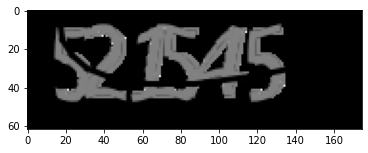

In [10]:
#Lets test an unknown captcha
#preview
%matplotlib inline 
import matplotlib.pyplot as plt
img=cv2.imread('data/test/521545.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [11]:
#Lets Predict By Model
print("Predicted Captcha =",predict('data/test/521545.png', model))

Predicted Captcha = 525457


In [12]:
# 전체 모델을 HDF5 파일로 저장합니다
# '.h5' 확장자는 이 모델이 HDF5로 저장되었다는 것을 나타냅니다
model.save('model/wetax_captcha_model.h5')

In [13]:
# 가중치와 옵티마이저를 포함하여 정확히 동일한 모델을 다시 생성합니다
new_model = load_model('model/wetax_captcha_model.h5')

# 모델 구조를 출력합니다
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 62, 175, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 62, 175, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 31, 88, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 31, 88, 32)   4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [14]:
score = new_model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4], y_test[5]], verbose=2)
print('='*100)
print('New Model Test Loss and accuracy:', score)

5/5 - 0s - loss: 37.9702 - dense_1_loss: 36.2493 - dense_3_loss: 0.0439 - dense_5_loss: 0.4746 - dense_7_loss: 0.2236 - dense_9_loss: 0.7355 - dense_11_loss: 0.2432 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 0.9925 - dense_5_accuracy: 0.9925 - dense_7_accuracy: 0.9627 - dense_9_accuracy: 0.9328 - dense_11_accuracy: 0.9701
New Model Test Loss and accuracy: [37.970245361328125, 36.24934768676758, 0.043918583542108536, 0.4746251106262207, 0.2235681563615799, 0.7355453968048096, 0.243243008852005, 0.0, 0.9925373196601868, 0.9925373196601868, 0.9626865386962891, 0.9328358173370361, 0.9701492786407471]


In [15]:
# Check model on some samples
model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4], y_test[5]])
print('='*100)
print(predict('data/test/028885.png', new_model))
print(predict('data/test/049858.png', new_model))
print(predict('data/test/339524.png', new_model))
print(predict('data/test/366405.png', new_model))
print(predict('data/test/400567.png', new_model))

5/5 [==============================] - 0s 8ms/step - loss: 37.9702 - dense_1_loss: 36.2493 - dense_3_loss: 0.0439 - dense_5_loss: 0.4746 - dense_7_loss: 0.2236 - dense_9_loss: 0.7355 - dense_11_loss: 0.2432 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 0.9925 - dense_5_accuracy: 0.9925 - dense_7_accuracy: 0.9627 - dense_9_accuracy: 0.9328 - dense_11_accuracy: 0.9701        
018885
049058
339524
366405
400567
